<a href="https://colab.research.google.com/github/BCImonk/Music-Generation-using-LSTM/blob/main/Capstone_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Libraries

In [ ]:
#Importing Libraries
!pip install music21
!apt-get install -y lilypond
!pip install pretty_midi
import pretty_midi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35 ghostscript
  libfontenc1 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libptexenc1
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lilypond-data
  lilypond-fonts lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x lilypond-doc
  python3-lxml poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho fonts-japanese-gothic
  | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern

# 2. Loading Data

In [ ]:
# Path to your zip file
zip_file_path = "/MIDI Dataset Capstone.zip"  # Replace 'your_file.zip' with the name of your file

# Create a new folder for extraction
output_folder = "/MIDI Dataset Capstone"  # Replace 'unzipped_folder' with your desired folder name
os.makedirs(output_folder, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

print(f"Contents unzipped to: {output_folder}")

Contents unzipped to: /MIDI Dataset Capstone


In [ ]:
#Loading the list of chopin's midi files as stream
filepath = "/MIDI Dataset Capstone/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath + i
        midi = converter.parse(tr)
        all_midis.append(midi)

In [ ]:
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


# 3. Data Exploration and Visualisation

In [ ]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['8.1', 'C#4', '9.1', '9.11', 'F#3', 'F#2', 'F#4', 'D5', 'D4', '8.1', 'C#4', '9.1', '9.11', 'F#3', 'A2', 'G#4', 'F#5', 'F#4', '6.10', 'F#4', '2.8', '11.1', 'B3', 'D3', 'G#4', 'F5', 'F4', '9.0', 'A4', '1.5', '1.2', 'B3', 'C#3', 'B4', 'G#5', 'G#4', '8.1', 'C#4', '9.1', '9.11', 'F#3', 'F#2', 'F#4', 'D5', 'D4', '8.1', 'C#4', '9.1', '9.11', 'F#3']


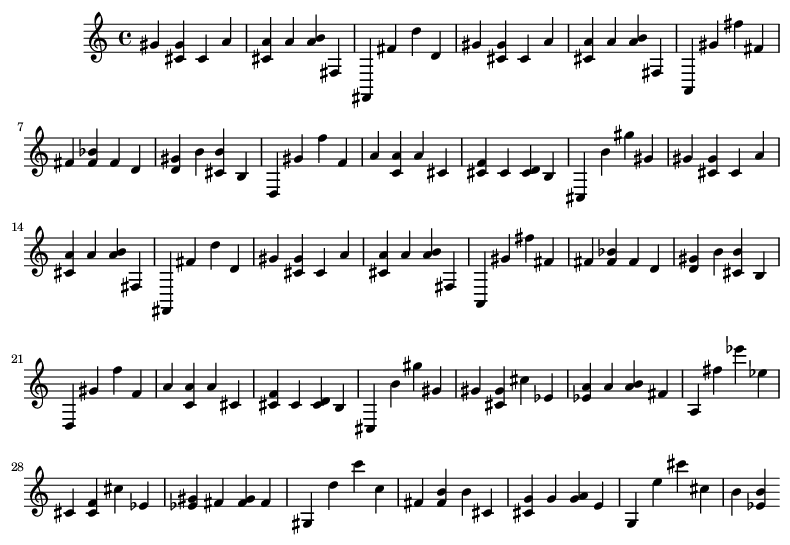

In [ ]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
'''
# Install necessary dependencies
!apt-get install -y fluidsynth  # Synthesizer for MIDI files
!pip install midi2audio

# Import libraries
from midi2audio import FluidSynth
import IPython.display as ipd
import os

# Define the path to the MIDI file
midi_file_path = "/MIDI Dataset Capstone/chopin/chp_op18.mid"
output_audio_file = "/output_audio.wav"  # Path for the synthesized audio file

# Check if the MIDI file exists
if not os.path.exists(midi_file_path):
    print(f"Error: The MIDI file does not exist at path: {midi_file_path}")
else:
    print("MIDI file found. Converting to audio...")

    # Synthesize MIDI to WAV using FluidSynth
    fs = FluidSynth()
    fs.midi_to_audio(midi_file_path, output_audio_file)

    # Play the synthesized audio
    print("Conversion complete. Playing audio:")
    ipd.Audio(output_audio_file)
'''

'\n# Install necessary dependencies\n!apt-get install -y fluidsynth  # Synthesizer for MIDI files\n!pip install midi2audio\n\n# Import libraries\nfrom midi2audio import FluidSynth\nimport IPython.display as ipd\nimport os\n\n# Define the path to the MIDI file\nmidi_file_path = "/MIDI Dataset Capstone/chopin/chp_op18.mid"\noutput_audio_file = "/output_audio.wav"  # Path for the synthesized audio file\n\n# Check if the MIDI file exists\nif not os.path.exists(midi_file_path):\n    print(f"Error: The MIDI file does not exist at path: {midi_file_path}")\nelse:\n    print("MIDI file found. Converting to audio...")\n\n    # Synthesize MIDI to WAV using FluidSynth\n    fs = FluidSynth()\n    fs.midi_to_audio(midi_file_path, output_audio_file)\n\n    # Play the synthesized audio\n    print("Conversion complete. Playing audio:")\n    ipd.Audio(output_audio_file)\n'

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


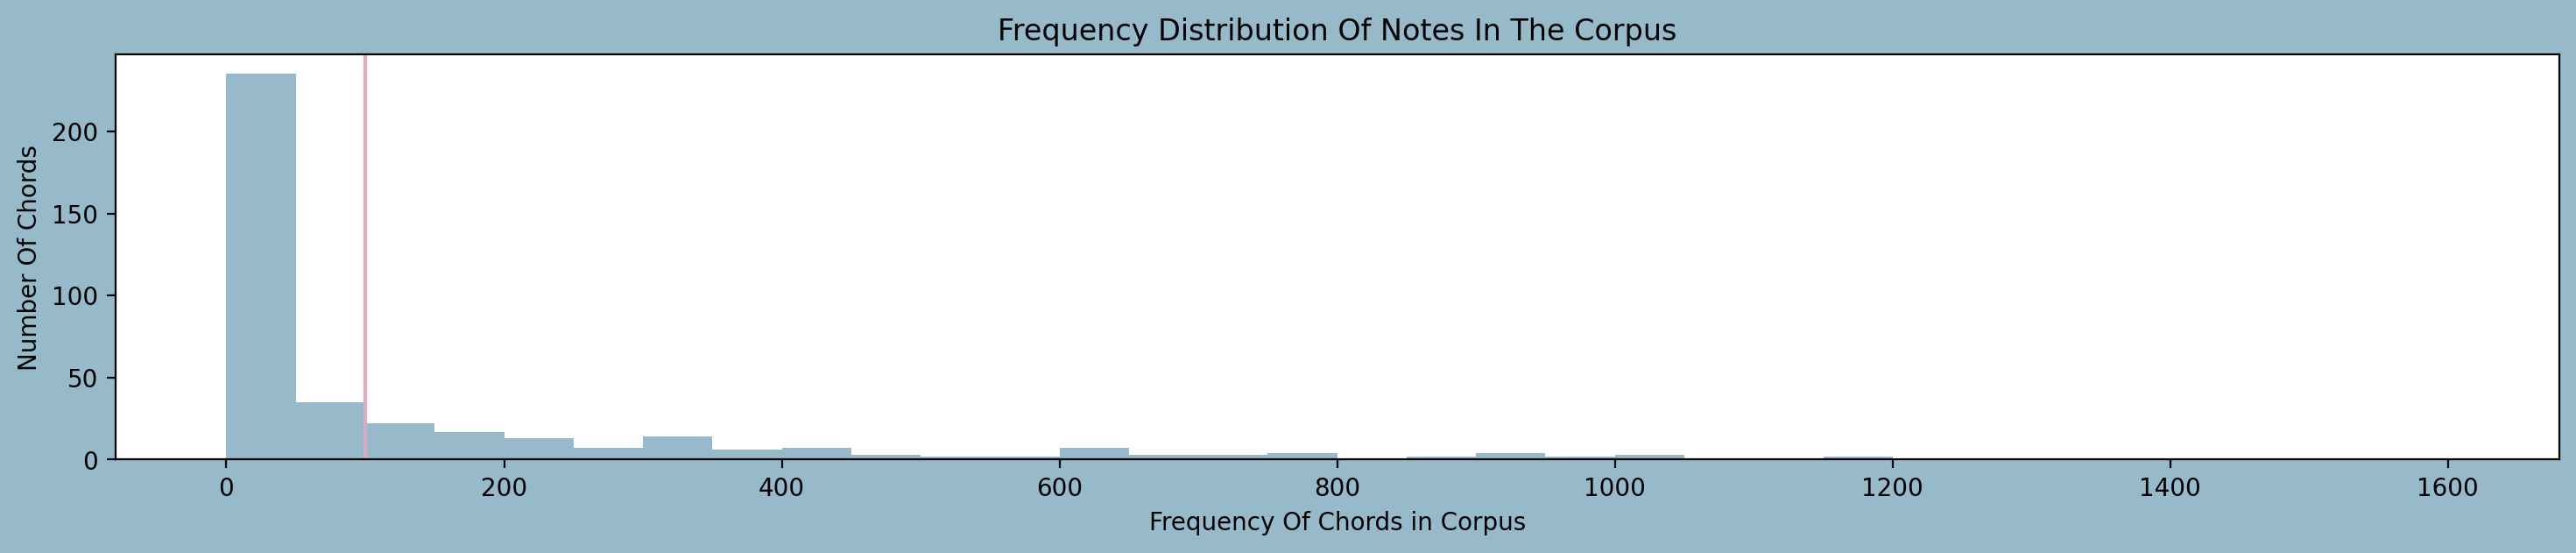

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

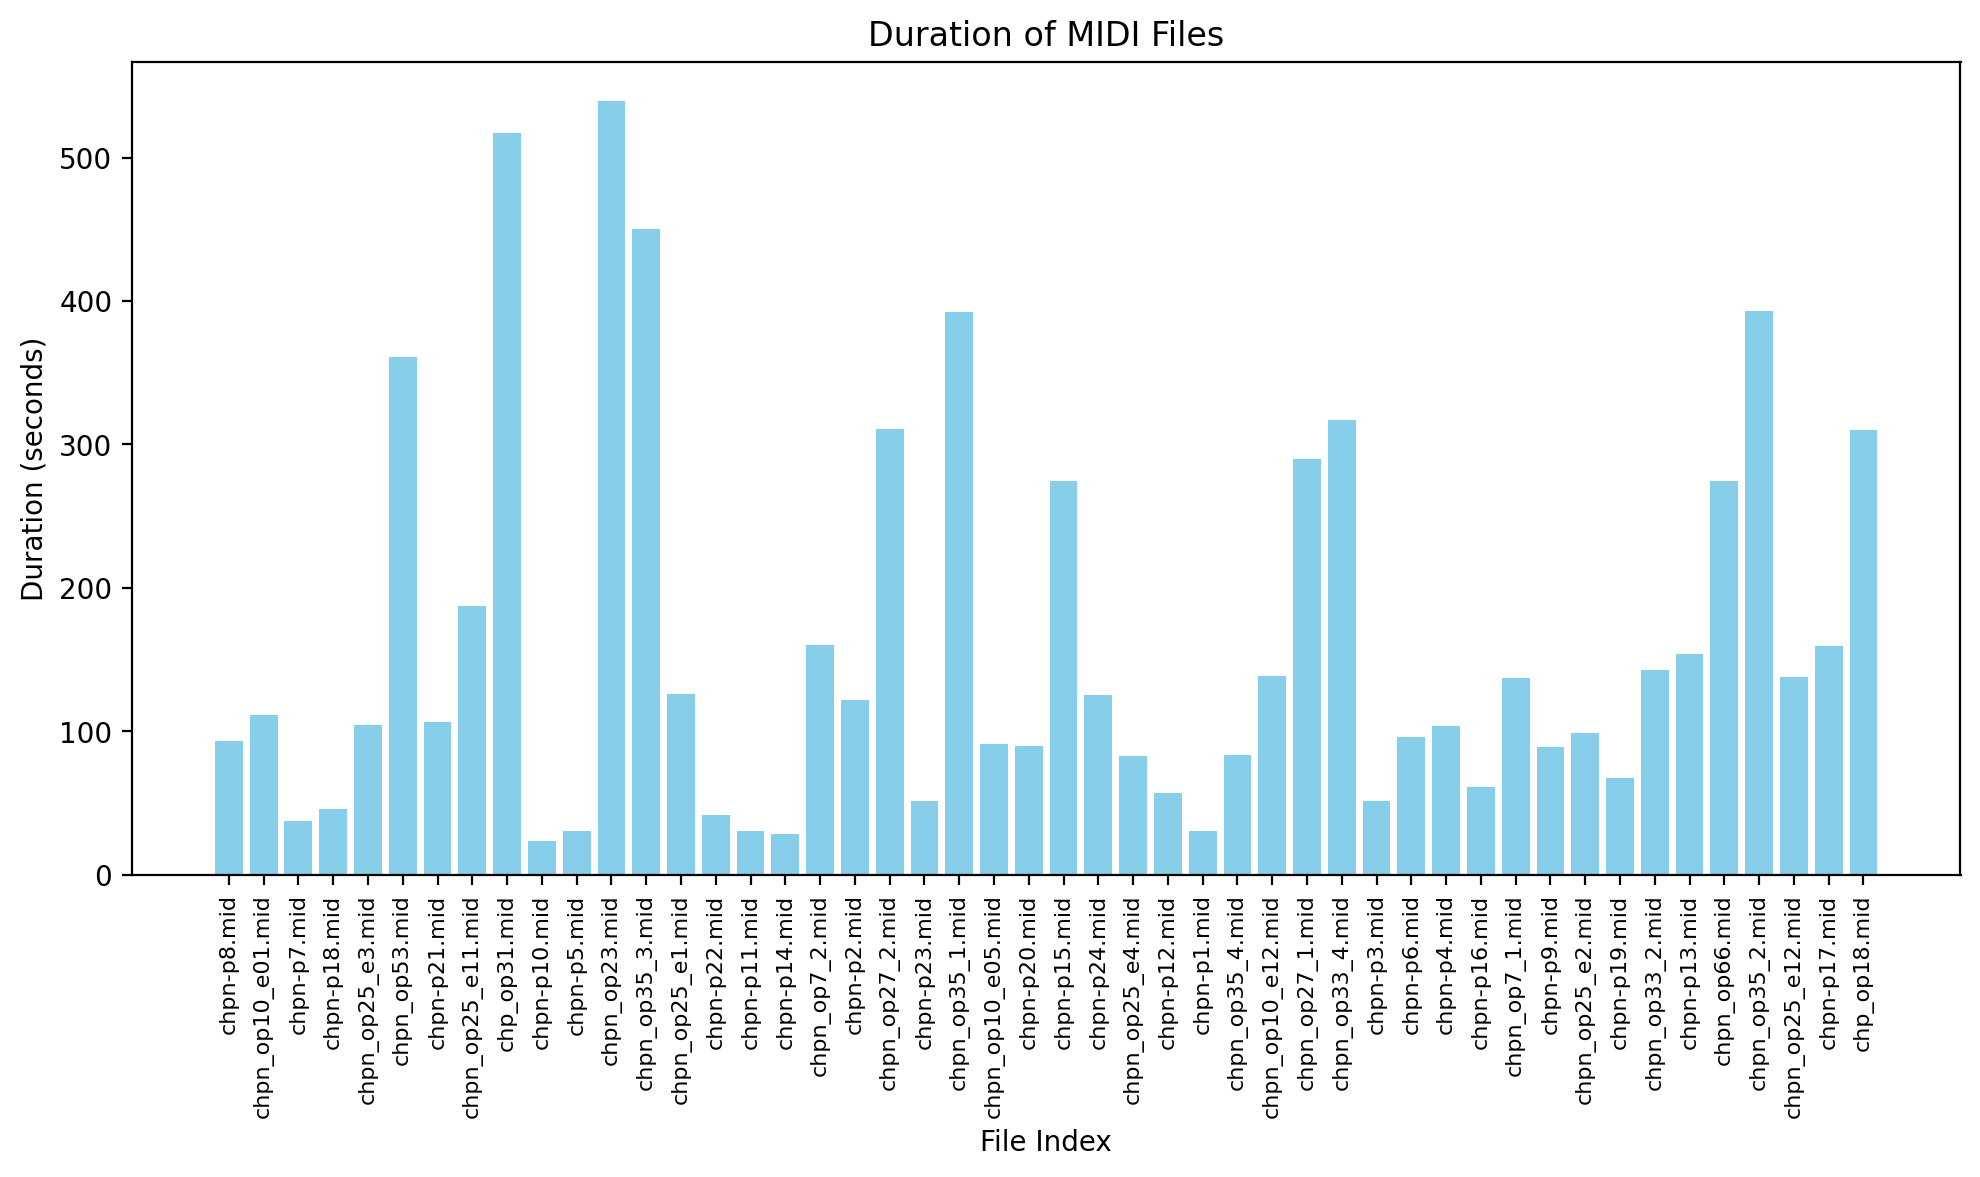

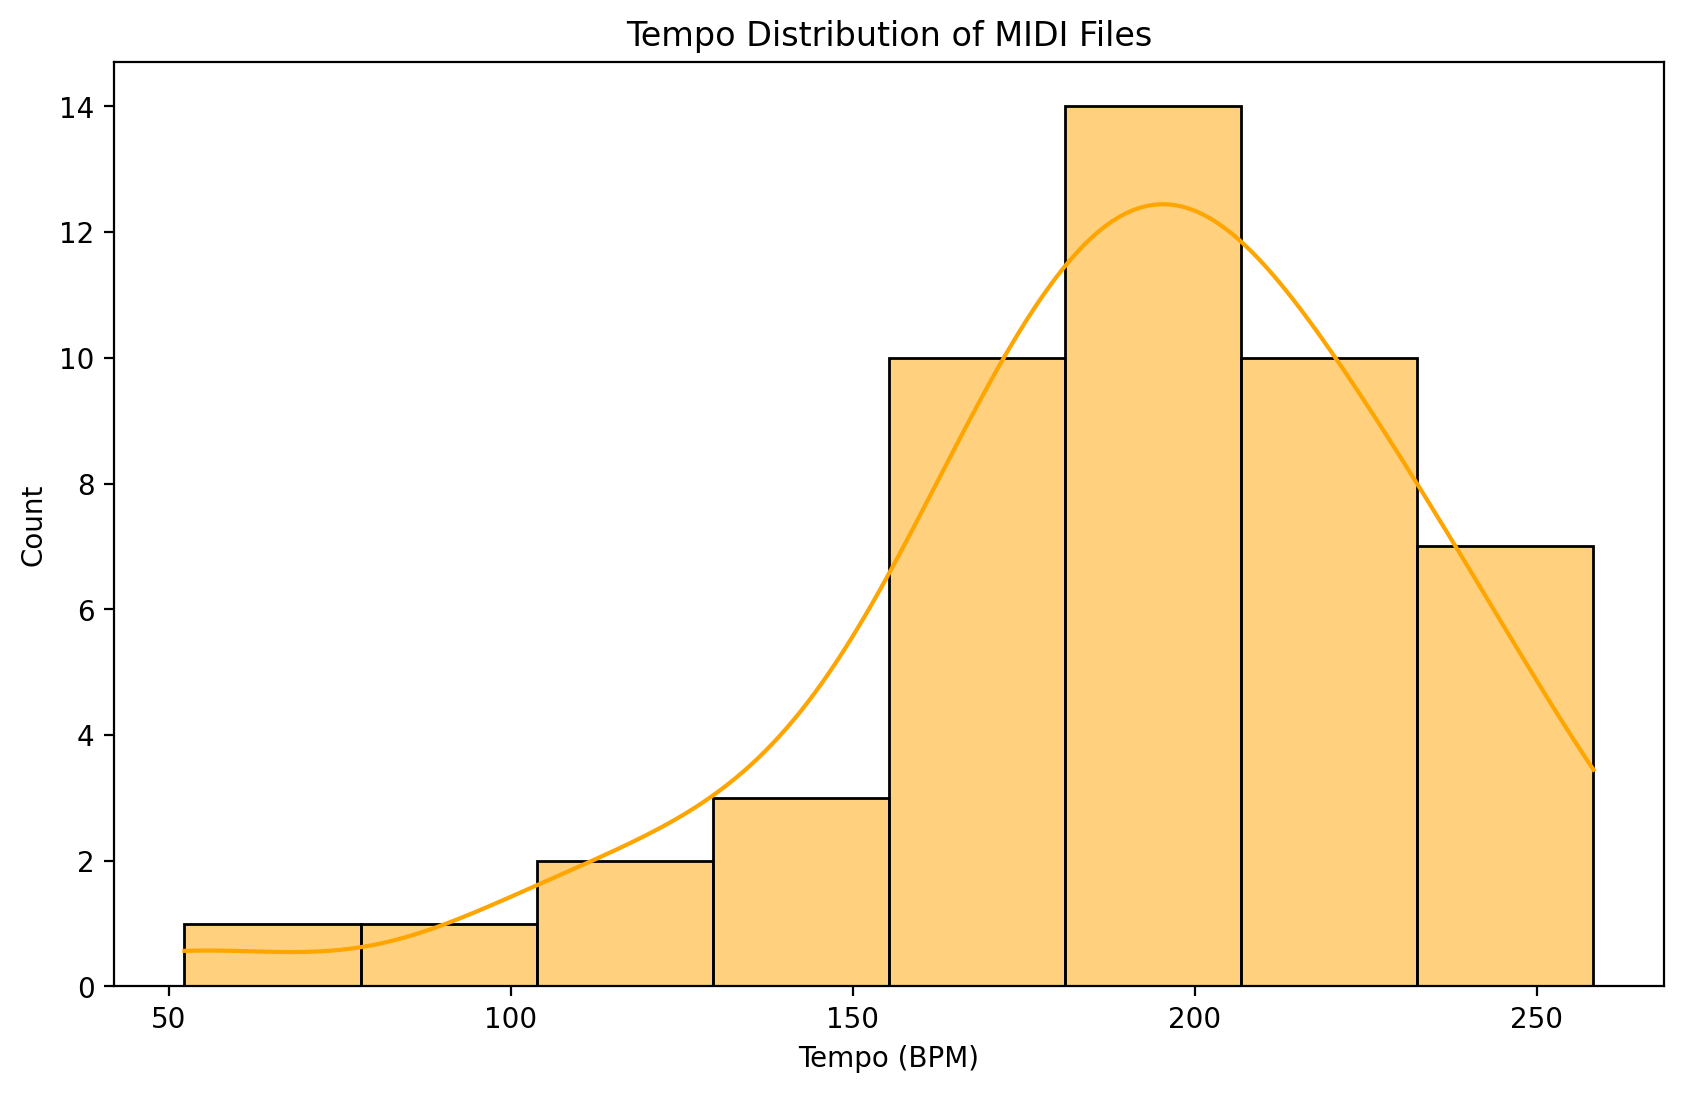

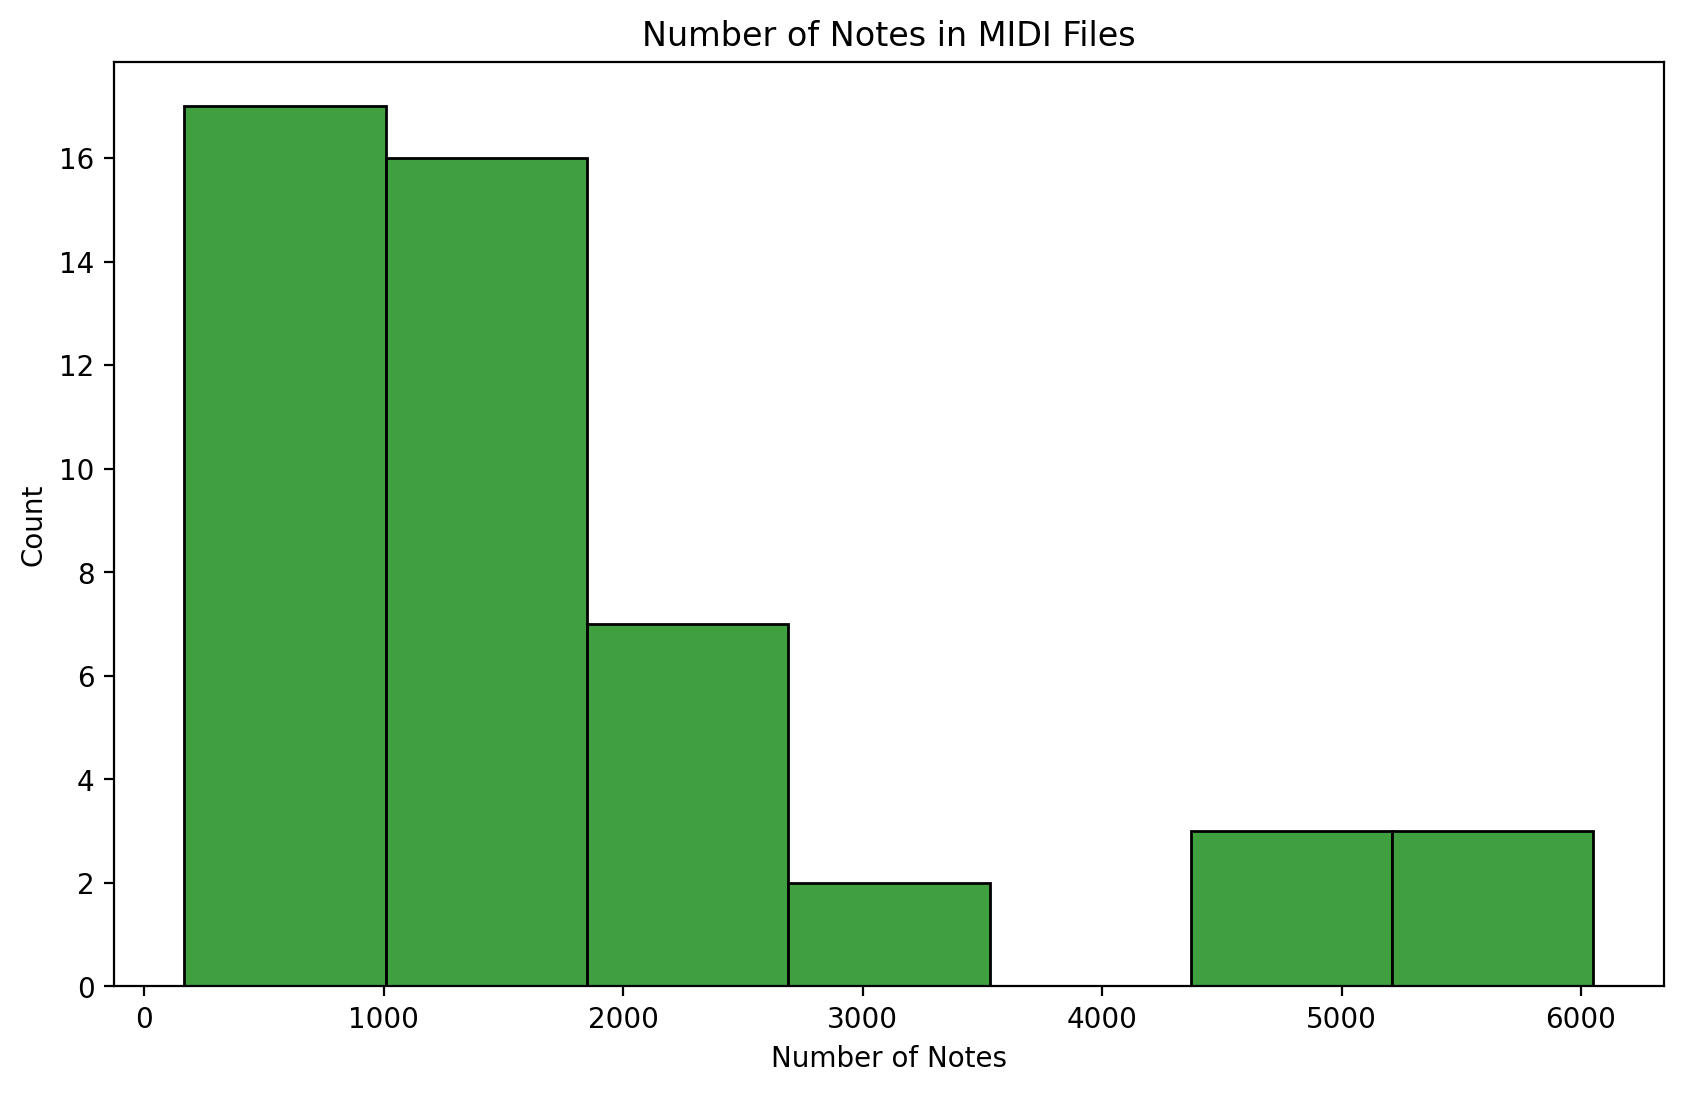

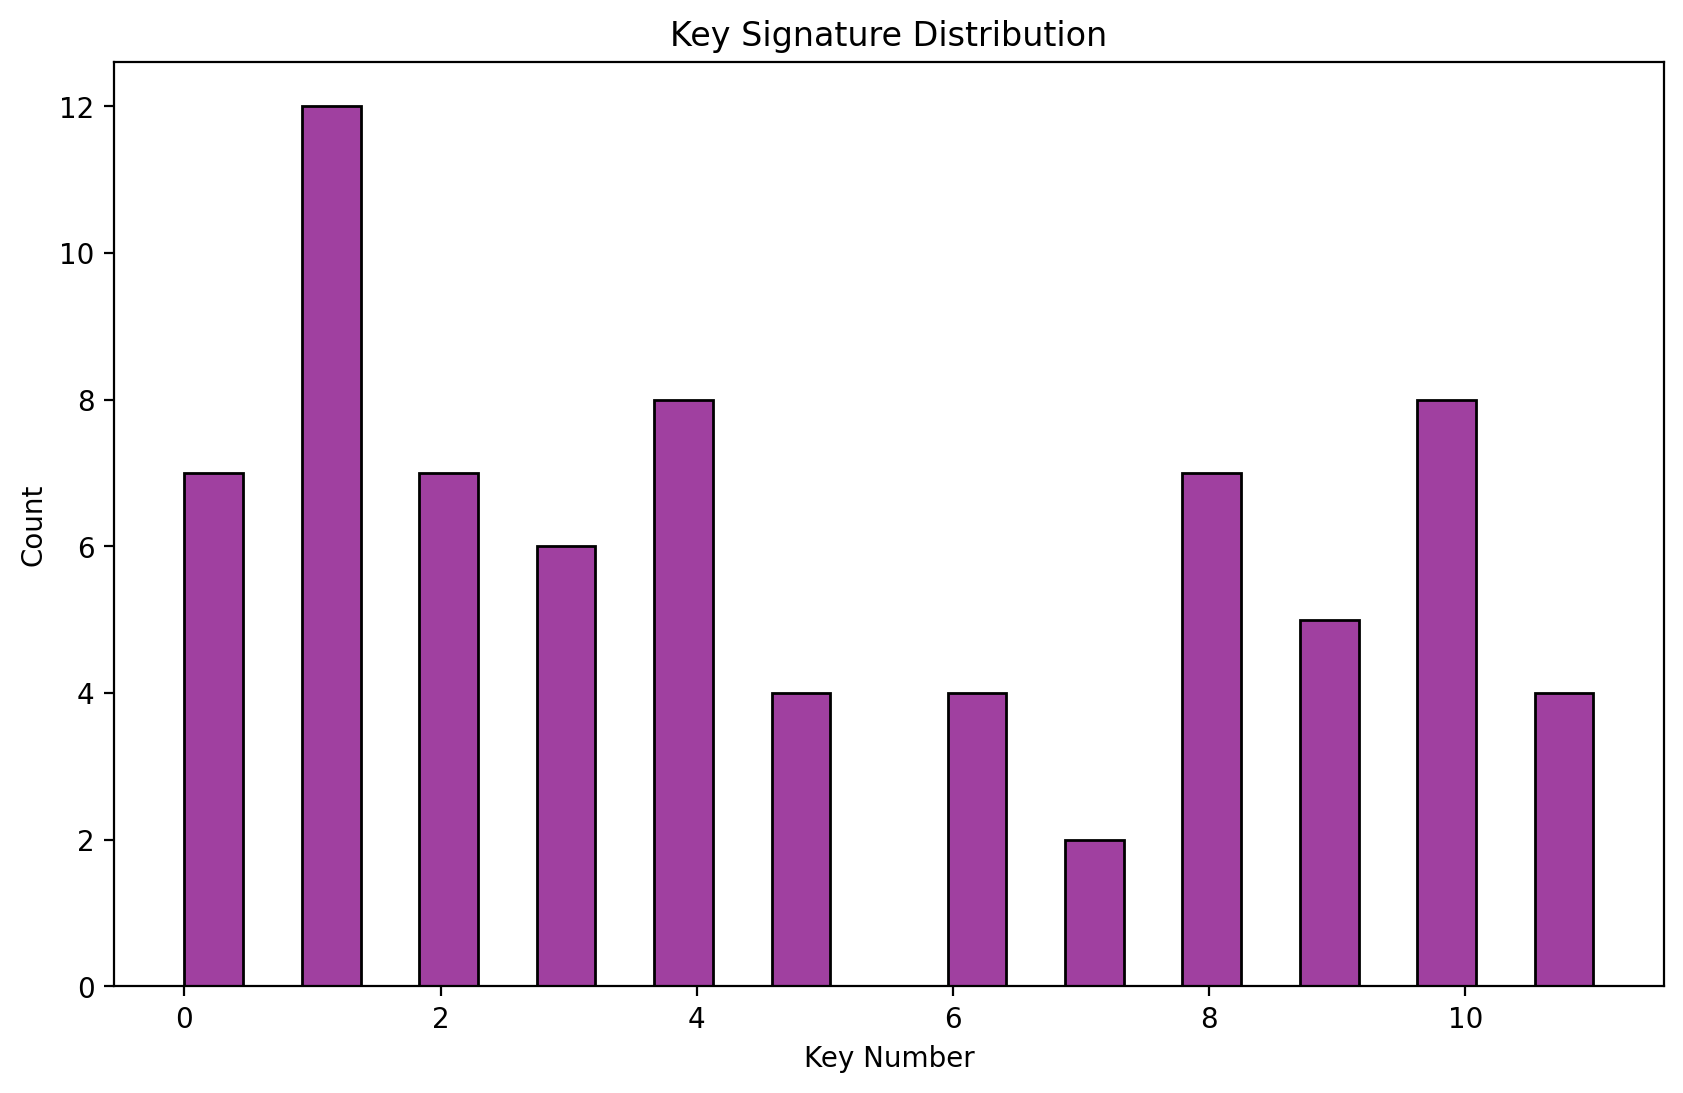

In [ ]:
# Path to your folder containing MIDI files
midi_folder_path = "/MIDI Dataset Capstone/chopin"

# Collect features for all MIDI files
durations = []
tempos = []
note_counts = []

for file in os.listdir(midi_folder_path):
    if file.endswith(".mid"):
        file_path = os.path.join(midi_folder_path, file)
        try:
            # Load MIDI file
            midi_data = pretty_midi.PrettyMIDI(file_path)

            # Extract features
            durations.append(midi_data.get_end_time())
            tempos.append(np.mean(midi_data.estimate_tempo()))  # Mean tempo
            note_counts.append(sum(len(inst.notes) for inst in midi_data.instruments))
        except Exception as e:
            print(f"Error processing {file}: {e}")

# 1. Bar Chart of File Durations
plt.figure(figsize=(10, 6))
plt.bar(range(len(durations)), durations, color='skyblue')
plt.title("Duration of MIDI Files")
plt.xlabel("File Index")
plt.ylabel("Duration (seconds)")
plt.xticks(range(len(durations)), os.listdir(midi_folder_path), rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

# 2. Histogram of Tempos
plt.figure(figsize=(10, 6))
sns.histplot(tempos, kde=True, color='orange')
plt.title("Tempo Distribution of MIDI Files")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Count")
plt.show()

# 3. Histogram of Notes
plt.figure(figsize=(10, 6))
sns.histplot(note_counts, kde=False, color='green')
plt.title("Number of Notes in MIDI Files")
plt.xlabel("Number of Notes")
plt.ylabel("Count")
plt.show()

# 4. Key Signature Analysis (if applicable)
keys = []
for file in os.listdir(midi_folder_path):
    if file.endswith(".mid"):
        file_path = os.path.join(midi_folder_path, file)
        try:
            midi_data = pretty_midi.PrettyMIDI(file_path)
            key_changes = midi_data.key_signature_changes
            keys.extend([kc.key_number for kc in key_changes])  # Extract key numbers
        except Exception as e:
            continue

if keys:
    plt.figure(figsize=(10, 6))
    sns.histplot(keys, kde=False, color='purple', bins=24)
    plt.title("Key Signature Distribution")
    plt.xlabel("Key Number")
    plt.ylabel("Count")
    plt.show()
else:
    print("No key signature information available in the dataset.")

In [ ]:
'''
import os
import pretty_midi
import matplotlib.pyplot as plt
import numpy as np

# Path to the dataset
midi_folder = "/content/drive/My Drive/Midi dataset/"

# Function to load MIDI files
def load_midi_files(midi_folder):
    midi_files = [f for f in os.listdir(midi_folder) if f.endswith('.mid')]
    return [pretty_midi.PrettyMIDI(os.path.join(midi_folder, f)) for f in midi_files]

# Function to plot note distribution
def plot_note_distribution(midi_data, title):
    all_notes = []
    for midi in midi_data:
        for instrument in midi.instruments:
            for note in instrument.notes:
                all_notes.append(note.pitch)

    plt.figure(figsize=(10, 6))
    plt.hist(all_notes, bins=np.arange(20, 108), color='skyblue', edgecolor='black')
    plt.title(f'Note Distribution for {title}')
    plt.xlabel('Note (MIDI Number)')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot tempo changes
def plot_tempo_changes(midi_data, title):
    for midi in midi_data:
        if midi.get_tempo_changes()[0].shape[0] > 1:  # check if there are tempo changes
            times, tempos = midi.get_tempo_changes()
            plt.figure(figsize=(10, 6))
            plt.plot(times, tempos, color='green')
            plt.title(f'Tempo Changes for {title}')
            plt.xlabel('Time (Seconds)')
            plt.ylabel('Tempo (BPM)')
            plt.show()

# Load and visualize the Chopin dataset
midi_data = load_midi_files(midi_folder)

# Example visualizations
plot_note_distribution(midi_data, 'Chopin')
plot_tempo_changes(midi_data, 'Chopin')
'''

'\nimport os\nimport pretty_midi\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Path to the dataset\nmidi_folder = "/content/drive/My Drive/Midi dataset/"\n\n# Function to load MIDI files\ndef load_midi_files(midi_folder):\n    midi_files = [f for f in os.listdir(midi_folder) if f.endswith(\'.mid\')]\n    return [pretty_midi.PrettyMIDI(os.path.join(midi_folder, f)) for f in midi_files]\n\n# Function to plot note distribution\ndef plot_note_distribution(midi_data, title):\n    all_notes = []\n    for midi in midi_data:\n        for instrument in midi.instruments:\n            for note in instrument.notes:\n                all_notes.append(note.pitch)\n\n    plt.figure(figsize=(10, 6))\n    plt.hist(all_notes, bins=np.arange(20, 108), color=\'skyblue\', edgecolor=\'black\')\n    plt.title(f\'Note Distribution for {title}\')\n    plt.xlabel(\'Note (MIDI Number)\')\n    plt.ylabel(\'Frequency\')\n    plt.show()\n\n# Function to plot tempo changes\ndef plot_tempo_changes(midi_dat

In [ ]:
'''
time_bins = np.linspace(0, 100, num=100)  # Time intervals
note_bins = np.arange(0, 128)  # MIDI note range

# Generate random frequency data for demonstration
frequency_data = np.random.randint(0, 10, size=(len(note_bins), len(time_bins)))

# Create a DataFrame
df = pd.DataFrame(frequency_data, index=note_bins, columns=time_bins)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Frequency'})
plt.title('Note Frequency Heatmap')
plt.xlabel('Time')
plt.ylabel('MIDI Note')
plt.show()
'''

"\ntime_bins = np.linspace(0, 100, num=100)  # Time intervals\nnote_bins = np.arange(0, 128)  # MIDI note range\n\n# Generate random frequency data for demonstration\nfrequency_data = np.random.randint(0, 10, size=(len(note_bins), len(time_bins)))\n\n# Create a DataFrame\ndf = pd.DataFrame(frequency_data, index=note_bins, columns=time_bins)\n\n# Plot heatmap\nplt.figure(figsize=(12, 6))\nsns.heatmap(df, cmap='viridis', cbar_kws={'label': 'Frequency'})\nplt.title('Note Frequency Heatmap')\nplt.xlabel('Time')\nplt.ylabel('MIDI Note')\nplt.show()\n"

# 4. Data Preprocessing

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [ ]:
#Eliminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53745


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53745
Number of unique characters: 255


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53705


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Building and Training

In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 40, 512)             │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 255)                 │          65,535 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,971,455 (7.52 MB)

 Trainable params: 1,971,455 (7.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=10)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 4.9360
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 4.6571
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.5798
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 4.5495
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 4.5467
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 4.5201
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 4.5131
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 4.4963
Epoch 9/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 4.4705
Epoch 10/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 4.4525


# 6. Model Evaluation

[Text(0.5, 0, 'Epochs')]

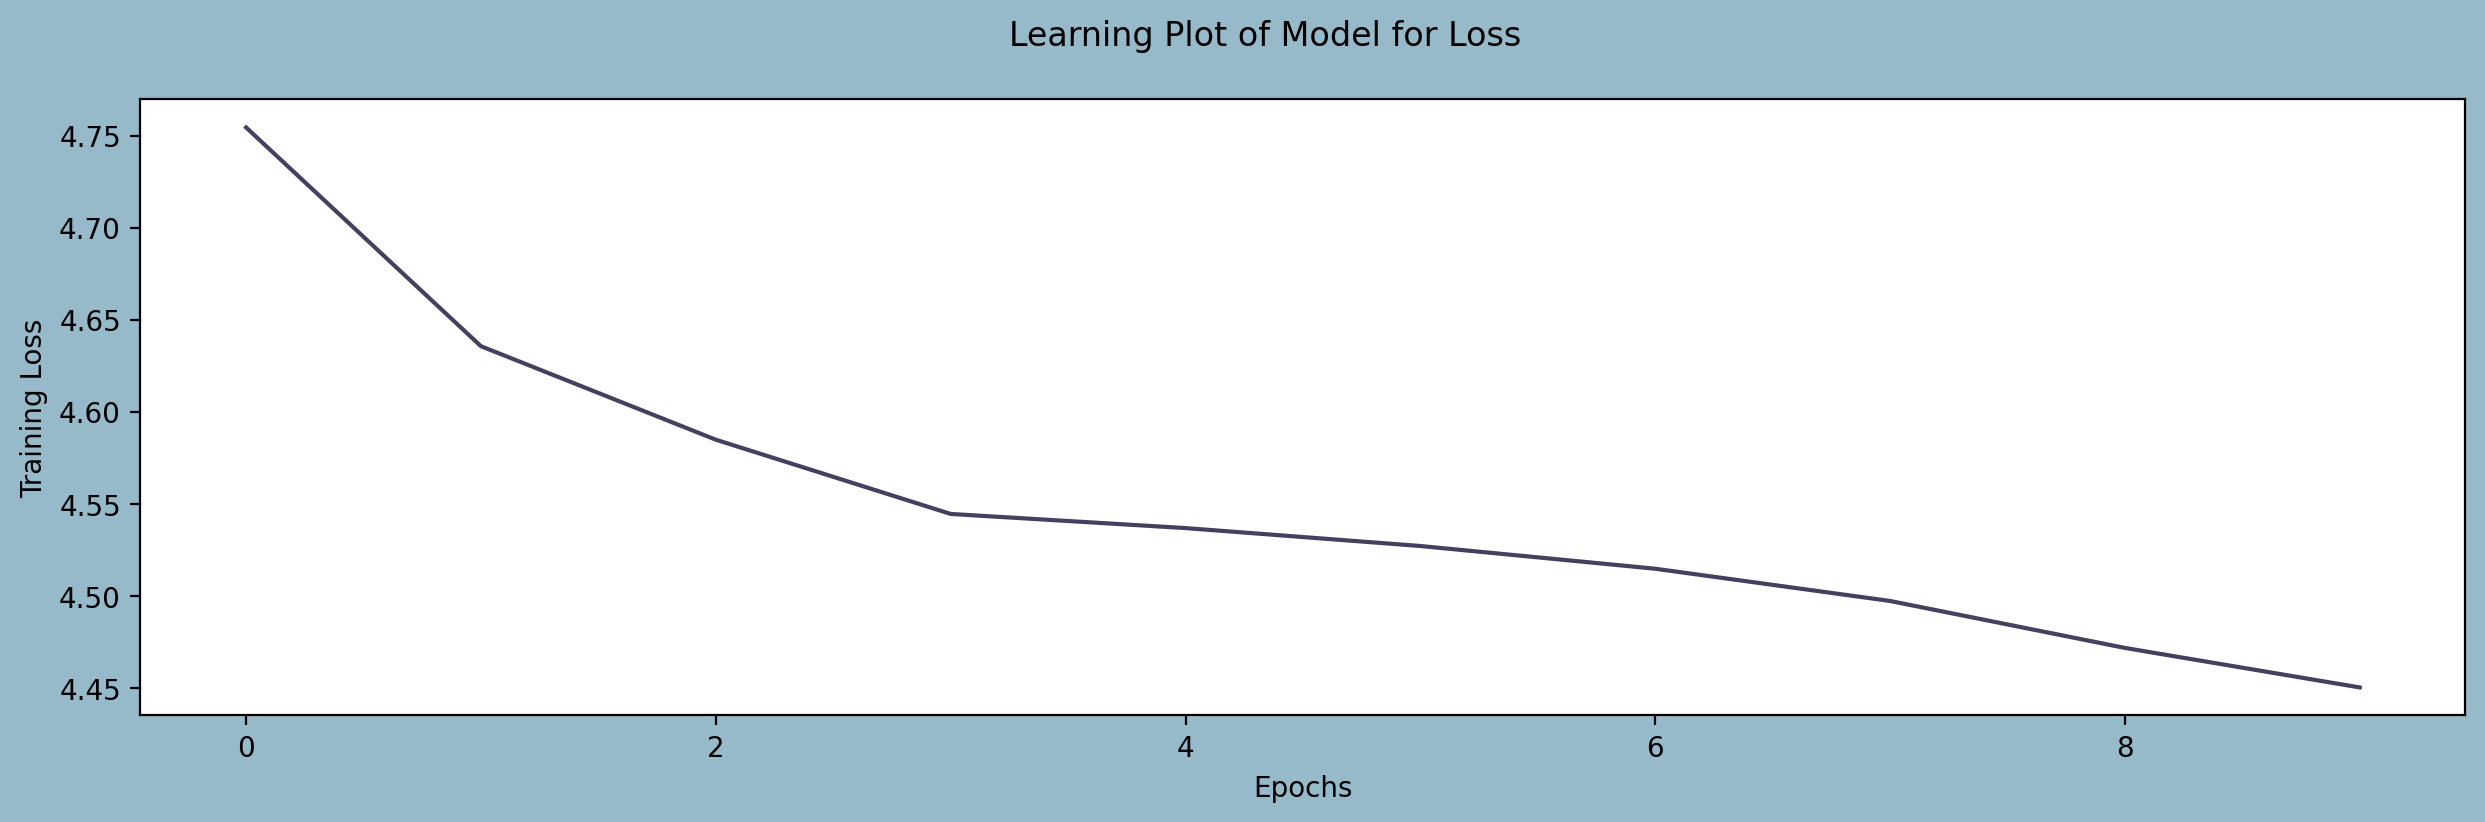

In [ ]:
#Plotting the learnings
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

# 7. Generating Tunes/ Output

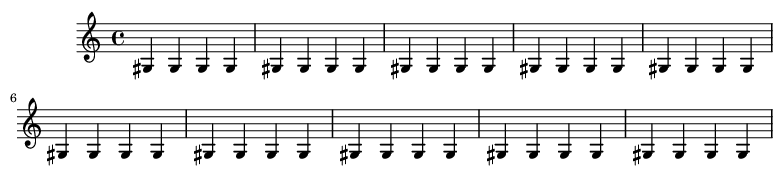

'Melody_Generated.mid'

In [ ]:
def Melody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Melody_Generator(40)
show(Melody)

Melody.write('midi','Melody_Generated.mid')